goal is to obtain butenedial decay rates as a function of pH

In [1]:
import os
notebook_wd = os.getcwd()
notebook_wd

'C:\\Users\\joh3146\\Documents\\pyrosolchem\\notebooks'

In [2]:
os.chdir(os.path.join(notebook_wd, '..'))

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")
sns.set_context("talk")

%matplotlib inline

from src.d00_utils.conf_utils import *
from src.d00_utils.data_utils import *
from src.d00_utils.plotting_utils import *

## 2020 Jan 09 
starting out looking at data without clear ph measurement. the ph are the expected amounts of a 1 M carbonate buffer, from a buffer table

In [24]:
csv_file_dir = os.path.join(notebook_wd, '..', 'data', '20200109_butenedial_decay.csv')
df = pd.read_csv(csv_file_dir)
df['sample'].unique()

array(['bd_ph9.6_d2o_001', 'bd_ph10_d2o_001', 'bd_ph10.4_d2o_001'],
      dtype=object)

have the right file name, now perform a simple plot to look at the data.

In [25]:
# need to fix the time column to plot
df['t'] = df['t_elapsed'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]) + int(x[2]) / 60)
df.t.head()

0     3.5
1     8.0
2    11.5
3    15.5
4    19.0
Name: t, dtype: float64

Text(0, 0.5, 'normalized butenedial signal')

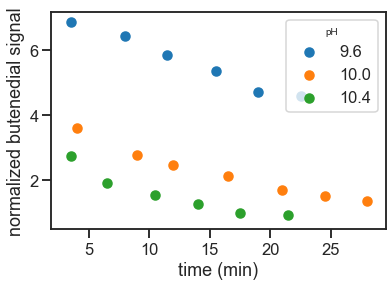

In [26]:
pHs = df.pH_est.unique()
N_sample = len(pHs)

fig, ax = plt.subplots(1,1)

for tick in range(N_sample):
    df_sub = df[df.pH_est == pHs[tick]]
    
    ax.scatter(df_sub.t, df_sub.bd_sig_norm, label=pHs[tick])
    
ax.legend(title='pH')
ax.set_xlabel('time (min)')
ax.set_ylabel('normalized butenedial signal')

notes: they should all start from the same signal (since the butenedial and dms molarity should have remained constant through experiments); looks somewhat exponential (can we assume that the pH remains roughly constant?? and if not, what does that say about the shapes of the lines and how they should be fit?)


for now i'll assume that ph is constant and extract first order rate terms. the ph can probably more accurately been taken with acetic acid shifts and then applied with the disproportionation function (see below).

In [27]:
df['ln_sig'] = np.log(df.bd_sig_norm)
df.ln_sig.head()

0    1.925707
1    1.860975
2    1.766442
3    1.677097
4    1.549688
Name: ln_sig, dtype: float64

Text(0, 0.5, 'log(normalized butenedial signal)')

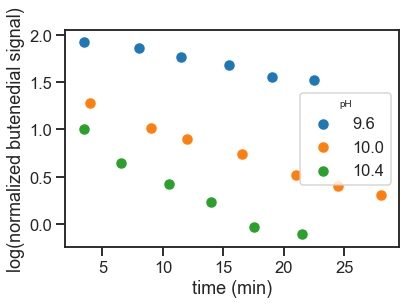

In [28]:
pHs = df.pH_est.unique()
N_sample = len(pHs)

fig, ax = plt.subplots(1,1)

for tick in range(N_sample):
    df_sub = df[df.pH_est == pHs[tick]]
    
    ax.scatter(df_sub.t, df_sub.ln_sig, label=pHs[tick])
    
ax.legend(title='pH')
ax.set_xlabel('time (min)')
ax.set_ylabel('log(normalized butenedial signal)')

looks approximately linear, but again, they should be going through the same y-intercept. i can only assume that there is a big ph shift in the beginning for the faster reactions.

perform linear regression with sklearn on the log data.

In [29]:
from src.d01_data.perform_ols import *
from sklearn.linear_model import LinearRegression

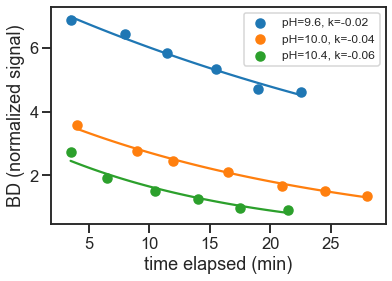

In [30]:
fig, ax = plt.subplots()

sns.set_context('talk')

for tick in range(N_sample):
    df_sub = df[df.pH_est == pHs[tick]]
    
    x_data = df_sub[df_sub.pH_est == pHs[tick]].t.values.reshape(-1, 1)
    y_data = df_sub[df_sub.pH_est == pHs[tick]].ln_sig.values

    b0, b1, score = perform_regression(x_data, y_data)
    xs, lnyhats = generate_linear_data(x_data, b0, b1)
    yhats = np.exp(lnyhats)

    label = 'pH=' + str(pHs[tick]) + ', k=' + str(b1[0])[0:5]
    ax.scatter(df_sub.t, df_sub.bd_sig_norm, label=label)
    ax.plot(xs, yhats)
    
ax.legend(prop={'size': 12})
ax.set_xlabel('time elapsed (min)')
ax.set_ylabel('BD (normalized signal)');

## 2020 Feb 20

Look at the data that was collected with calculated pH values, taken with NMR

In [31]:
csv_file_dir = os.path.join(notebook_wd, '..', 'data', '20200120_jch_butenedial_kinetics_nmr.csv')
df = pd.read_csv(csv_file_dir)
df['sample'].unique()

array(['bd_ph9.6_d2o_001', 'bd_ph10_d2o_001', 'bd_ph10.4_d2o_001',
       'bd_ph9.4_d2o_001', 'bd_ph10_d2o_002', 'bd_ph10_d2o_004',
       'bd_ph9.4_d2o_002', 'bd_ph9.2_d2o_002', 'bd_ph10.6_d2o_001',
       'bd_ph10.2_d2o_001'], dtype=object)

want only the two samples: bd_ph9.2_d2o_002 and bd_ph10.6_d2o_001

In [32]:
df = df[(df['sample'] == "bd_ph9.2_d2o_002") | (df['sample'] == "bd_ph10.2_d2o_001") | (df['sample'] == "bd_ph10.6_d2o_001")]
df['sample'].unique()

array(['bd_ph9.2_d2o_002', 'bd_ph10.6_d2o_001', 'bd_ph10.2_d2o_001'],
      dtype=object)

In [33]:
# need to fix the time column to plot
df['t'] = df['t_elapsed'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]) + int(x[2]) / 60)
df.t.head()

df['ln_sig'] = np.log(df.bd_sig_norm)
df.ln_sig.head()

45    0.378436
46    0.378436
47    0.336472
48    0.307485
49    0.300105
Name: ln_sig, dtype: float64

In [34]:
df.columns

Index(['sample', 'pH_est', 't_mix', 't_ nmr', 't_elapsed', 't_elapsed(mins)',
       'bd_sig_norm', 'ln(bd)', 'a_ppm_1', 'a_ppm_2', 'a_ppm_avg', 'a-_ppm',
       'ha_ppm', 'x_a-', 'x_a', 'pka', 'ph_calc', 'ph_calc_avg', 't',
       'ln_sig'],
      dtype='object')

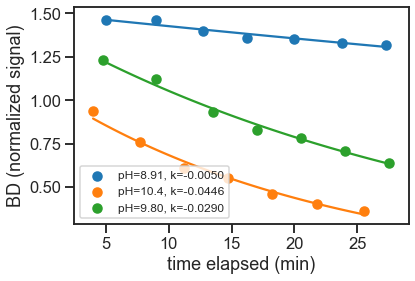

In [35]:
fig, ax = plt.subplots()

sns.set_context('talk')

pHs = df.ph_calc_avg.unique()
N = len(pHs)
b1s = np.empty(N)
for tick in range(N):
    df_sub = df[df.ph_calc_avg == pHs[tick]]
    
    x_data = df_sub[df_sub.ph_calc_avg == pHs[tick]].t.values.reshape(-1, 1)
    y_data = df_sub[df_sub.ph_calc_avg == pHs[tick]].ln_sig.values

    b0, b1, score = perform_regression(x_data, y_data)
    b1s[tick] = b1
    xs, lnyhats = generate_linear_data(x_data, b0, b1)
    yhats = np.exp(lnyhats)

    label = 'pH=' + str(pHs[tick])[0:4] + ', k=' + str(b1[0])[0:7]
    ax.scatter(df_sub.t, df_sub.bd_sig_norm, label=label)
    ax.plot(xs, yhats)
    
ax.legend(prop={'size': 12})
ax.set_xlabel('time elapsed (min)')
ax.set_ylabel('BD (normalized signal)');

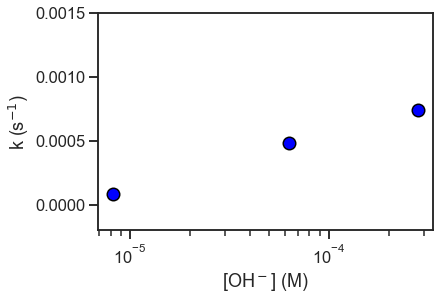

In [36]:
ks = -b1s/60

OHs = 10**(-14+pHs)

plt.semilogx(OHs, ks, '.', markersize=25, color='blue', markeredgecolor='black', markeredgewidth=1.5)
plt.ylim([-0.0002, 0.0015])
plt.xlabel('[OH$^-$] (M)')
plt.ylabel('k (s$^{-1}}$)');

now that the k constant has been extracted, attempt to get a1, a2, a3 (for franske & reilly equations). but require an additional k data point (because there are three coefficients to retrieve), so need to perform one more time at a different pH.

In [37]:
from scipy.optimize import curve_fit
import math

def disproportionation(OH, a1, a2, a3):
    
    return (a1*OH + a2*OH*OH)/(1 + a3*OH)

ks = -b1s/60
OHs = 10**(-14+pHs)
print(OHs)
a, acov = curve_fit(disproportionation, OHs, ks, p0=(1, 1, 1), bounds=([0, 0, 0], [10000, 1000, 100000000]))

print(acov)
print(a)

[8.24583613e-06 2.79475949e-04 6.32147979e-05]
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]]
[1.54011328e+01 1.90106500e-01 1.69667618e+04]


C:\Users\joh3146\AppData\Local\Continuum\anaconda3\envs\dropletenv\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


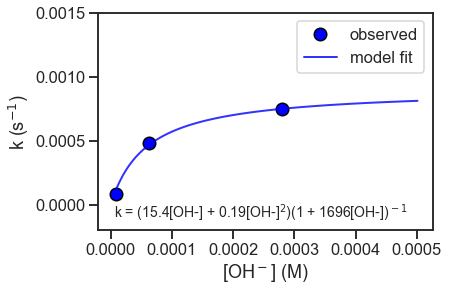

In [91]:
oh = np.logspace(-5.4, -3.3, num=100)
k = disproportionation(oh, a[0], a[1], a[2])

plt.plot(OHs, ks, '.', markersize=25, color='blue', markeredgecolor='black', markeredgewidth=1.5, label='observed')
plt.plot(oh, k, color='blue', alpha=0.8, linewidth=2, label='model fit')
plt.ylim([-0.0002, 0.0015])
plt.xlabel('[OH$^-$] (M)')
plt.ylabel('k (s$^{-1}}$)')
plt.legend()

num_text = str(a[0])[0:4] + '[OH-]' + ' + ' + str(a[1])[0:4] + '[OH-]$^2$'
denom_text = '1 + ' + str(a[2])[0:4] + '[OH-]'

plot_text = 'k = ({})({})$^-$$^1$'.format(num_text,denom_text)

plt.text(5e-6, -0.0001, plot_text, fontsize=14);

where does butenedial decay fit on this curve?

In [39]:
bd_nh3g_expts = load_experiments(['bd_rxn_nh3g_droplet'])
bd_nh3g_expts.keys()

dict_keys(['bd_rxn_nh3g_droplet'])

In [40]:
bd_nh3g_file_name = bd_nh3g_expts['bd_rxn_nh3g_droplet']['paths']['raw_data']
df_bd_nh3g = import_ms_data(bd_nh3g_file_name)
df_bd_nh3g.columns

Index(['Unnamed: 0', 'p149', 'p283', 'p84', 'p85', 'p112', 'p122', 'p150',
       'p168', 'trapped', 'nh3', 'signal_84', 'signal_85', 'signal_149',
       'solution', 'np84', 'np85', 'np149', 'nominal_nh3_mM'],
      dtype='object')

Text(0.5, 4.5, 'time (s)')

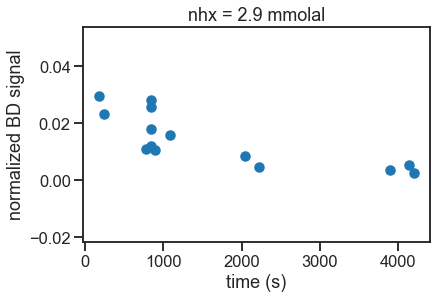

In [49]:
nh3_to_plot = 2.9
df_bd_nh3g['n85'] = df_bd_nh3g['p85']/df_bd_nh3g['p283']
df_bd_nh3g['s'] = df_bd_nh3g['trapped']*60
                              
species_to_plot = ['n85']
num_species = len(species_to_plot)

fig, ax = plt.subplots()
fig.tight_layout()

df_to_plot = df_bd_nh3g[df_bd_nh3g.nominal_nh3_mM == nh3_to_plot]

for tick in range(num_species):
    species = species_to_plot[tick]
    ax.scatter(df_to_plot.s, df_to_plot[species])
    title_string = 'nhx = ' + str(nh3_to_plot) + ' mmolal'
    ax.set_ylabel('normalized BD signal')

ax.set_title(title_string)
ax.set_xlabel('time (s)')

extract a decay constant from this data

In [45]:
from src.d01_data.perform_ols import *
from sklearn.linear_model import LinearRegression

In [50]:
df_bd_nh3g['ln85'] = np.log(df_bd_nh3g.n85)
df_bd_nh3g['ln85'].head()

0   -6.055043
1   -5.951944
2   -5.676780
3   -7.194898
4   -5.728253
Name: ln85, dtype: float64

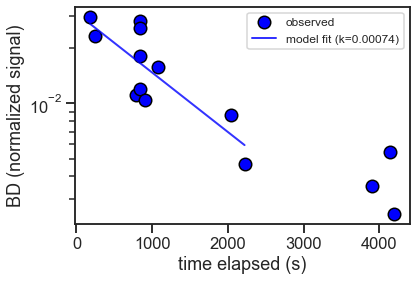

In [119]:
fig, ax = plt.subplots()

df_sub = df_bd_nh3g[df_bd_nh3g.nominal_nh3_mM == nh3_to_plot]
df_sub_short_time = df_sub[df_sub.s < 3000]

x_data = df_sub_short_time.s.values.reshape(-1, 1)
y_data = df_sub_short_time.ln85.values

x_data_short = df_sub_short_time.s.values.reshape(-1, 1)
y_data_short = df_sub_short_time.ln85.values 

b0, b1, score = perform_regression(x_data, y_data)
xs, lnyhats = generate_linear_data(x_data, b0, b1)
yhats = np.exp(lnyhats)

label =  'k=' + str(b1[0])[1:8]
ax.semilogy(df_sub.s, df_sub.n85, '.', markersize=25, color='blue', markeredgecolor='black', markeredgewidth=1.5, label='observed')
ax.semilogy(xs, yhats, color='blue', alpha=0.8, linewidth=2, label='model fit (%s)' % label)
    
ax.legend(prop={'size': 12})
ax.set_xlabel('time elapsed (s)')
ax.set_ylabel('BD (normalized signal)');

In [120]:
from scipy.optimize import fsolve

def disproportionation_root_fn(OH):
    
    return (a[0]*OH + a[1]*OH*OH)/(1 + a[2]*OH) + b1[0]

OH_est = fsolve(disproportionation_root_fn, 0)
OH_est

array([0.00026803])

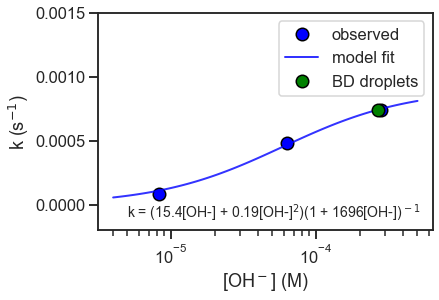

In [121]:
oh = np.logspace(-5.4, -3.3, num=100)
k = disproportionation(oh, a[0], a[1], a[2])

plt.semilogx(OHs, ks, '.', markersize=25, color='blue', markeredgecolor='black', markeredgewidth=1.5, label='observed')
plt.semilogx(oh, k, color='blue', alpha=0.8, linewidth=2, label='model fit')
plt.semilogx(OH_est, -b1[0], '.', markersize=25, color='green', markeredgecolor='black', 
             markeredgewidth=1.5, label='BD droplets')
plt.ylim([-0.0002, 0.0015])
plt.xlabel('[OH$^-$] (M)')
plt.ylabel('k (s$^{-1}}$)')
plt.legend()

num_text = str(a[0])[0:4] + '[OH-]' + ' + ' + str(a[1])[0:4] + '[OH-]$^2$'
denom_text = '1 + ' + str(a[2])[0:4] + '[OH-]'

plot_text = 'k = ({})({})$^-$$^1$'.format(num_text,denom_text)

plt.text(5e-6, -0.0001, plot_text, fontsize=14);

In [111]:
pOH_est = -np.log10(OH_est)
14-pOH_est

array([9.85584488])

it really seems like the pH might be changing substantially depending on the estimate (9.85 for the whole set, 10.44 for the first bit.) May make more sense to model the pH as changing.

In [149]:
bd_nh3g_file_name = bd_nh3g_expts['bd_rxn_nh3g_droplet']['paths']['clustered_data']
df_bd_nh3g_clustered = import_ms_data(bd_nh3g_file_name, subdirectory='bd_rxn_nh3g_droplet')
df_bd_nh3g_clustered.columns

Index(['mz84_mz283', 'mz85_mz283', 'mz149_mz283', 'mins', 'mz84_mz283_std',
       'mz85_mz283_std', 'mz149_mz283_std', 'mins_std', 'experiment'],
      dtype='object')

In [152]:
df_bd_nh3g_clustered.sort_values(['mins'], ascending=[1], inplace=True)
df_bd_nh3g_clustered = df_bd_nh3g_clustered.reset_index(drop=True)

In [187]:
del_ts = np.empty(3)
del_BDs = np.empty(3)
for tick in range(3):
    del_ts[tick] = 60*(df_bd_nh3g_clustered.mins[tick+1]-df_bd_nh3g_clustered.mins[tick])
    del_BDs[tick] = df_bd_nh3g_clustered.mz85_mz283[tick+1]-df_bd_nh3g_clustered.mz85_mz283[tick]

In [199]:
OHs = []
for tick in range(3):
    BD = df_bd_nh3g_clustered.mz85_mz283[tick]
    dBDdt = -del_BDs[tick]/del_ts[tick]
    
    def disproportionation_discretized(OH):
    
        return (a[0]*OH + a[1]*OH*OH)/(1 + a[2]*OH)*BD - dBDdt
    
    OH = fsolve(disproportionation_discretized, 0)
    OHs.append(OH)

print(OHs)

[array([4.71808664e-05]), array([6.93474738e-05]), array([1.86466365e-05])]


In [200]:
pOHs = -np.log10(OHs)
pHs = 14-pOHs
print(pHs)

[[9.67376591]
 [9.84103065]
 [9.2706005 ]]


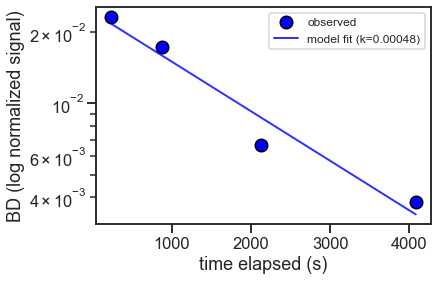

In [206]:
fig, ax = plt.subplots()

df_sub = df_bd_nh3g_clustered
df_sub['ln85'] = np.log(df_bd_nh3g_clustered.mz85_mz283)

x_data = df_sub.mins.values.reshape(-1, 1) * 60
y_data = df_sub.ln85.values

b0, b1, score = perform_regression(x_data, y_data)
xs, lnyhats = generate_linear_data(x_data, b0, b1)
yhats = np.exp(lnyhats)

label =  'k=' + str(b1[0])[1:8]
ax.semilogy(df_sub.mins*60, df_sub.mz85_mz283, '.', markersize=25, color='blue', markeredgecolor='black', markeredgewidth=1.5, label='observed')
ax.semilogy(xs, yhats, color='blue', alpha=0.8, linewidth=2, label='model fit (%s)' % label)
    
ax.legend(prop={'size': 12})
ax.set_xlabel('time elapsed (s)')
ax.set_ylabel('BD (log normalized signal)');